<a href="https://colab.research.google.com/github/stefsyrsiri/synthetic-image-detection/blob/stef/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting AI-Generated Synthetic Images

The boom of AI-powered content generation and increasing interest in the research field of Deep Learning has led to widely accessible (and trending) tools that can produce content of any kind: text, image, audio, and video. This high GenAI trend has even led to the advancedment of existing tools, that had been forgotten. AI-generated content can often be indistinguishable from its authentic counterparts, posing a threat to the credibility of digital media. The underlying dangers of the misuse of GenAI have already come to surface with deepfakes, voice cloning, fakes news, disinformation, identity theft and various types of scams.

In this report, we focus on image generation, which can have multiple societal effects, especially on people not familiar with this kind of technology. Our task is to train a neural network to identify whether an image is real or AI-generated.



In [ ]:
# Project overview
# TO-DO: Add statistics from credible sources / read papers
# TO-DO: Find media to add / Try to find high-res images from the dataset
# 1. CNN
# 2. Transfer learning
# 3. Demo

In [28]:
# Import packages and custom functions
# Data Handling
import os
import sys
from PIL import Image
import time
import pandas as pd
import numpy as np
import tempfile


# PyTorch and CV
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import InterpolationMode, v2
import torchvision.transforms.v2 as v2_transforms
import cv2

# Visualization and Evaluation
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE

# Classes
!git clone https://github.com/stefsyrsiri/synthetic-image-detection.git
sys.path.append('/content/synthetic-image-detection')
from functions import *
from testpy import test
test

#TO-DO: Do we need the following?
# import tensorflow
# from tensorflow.keras import Model #Model class for instantiating the ResNet that you will be creating.


# #These are all described in standard deep learning literature (e.g. Conv2Dor Dense). Why they are necessary can be found in the He et al. (2016) paper.
# from tensorflow.keras.layers import Add, GlobalAveragePooling2D,\
# Dense, Flatten, Conv2D, Lambda, Input, BatchNormalization, Activation schedules and the Stochastic Gradient Descent optimizer for optimization purposes.
# from tensorflow.keras.optimizers import schedules, SGD

# For visualizing your training results and saving your model, respectively.
# from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


fatal: destination path 'synthetic-image-detection' already exists and is not an empty directory.


'>>^ω^<<'

## Dataset

The dataset we're using to train our classifier is **[CIFAKE: Real and AI-Generated Synthetic Images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)**, which can be found on Kaggle.

CIFAKE is a comprehensive collection of 60,000 synthetically-generated images and 60,000 real images (collected from CIFAR-10). The dataset contains two classes, labelled as "REAL" and "FAKE".

In [2]:
# The dataset exceeds Github's limits and needs to be downloaded directly from Kaggle
# Download CIFAKE dataset
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

# Unzip downloaded dataset (can be found in the Files on the left)
!unzip -q cifake-real-and-ai-generated-synthetic-images.zip

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
 98% 102M/105M [00:06<00:00, 19.9MB/s] 
100% 105M/105M [00:06<00:00, 16.4MB/s]


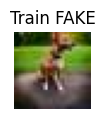

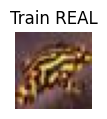

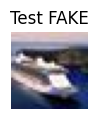

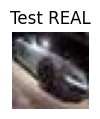

In [3]:
# Paths to the dataset
train_fake_path = './train/FAKE'
train_real_path = './train/REAL'
test_fake_path = './test/FAKE'
test_real_path = './test/REAL'

# Function to display an image
def show_image(title, path):
    image_files = os.listdir(path)
    img_path = os.path.join(path, image_files[6])  # Just take the first image for now
    img = Image.open(img_path)

    plt.figure(figsize=(1, 1))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')  # Hide the axis
    plt.show()

# TO-DO: Display the images nicely
# Show one image from each category
show_image('Train FAKE', train_fake_path)
show_image('Train REAL', train_real_path)
show_image('Test FAKE', test_fake_path)
show_image('Test REAL', test_real_path)

In [4]:
# Our classes' labels
print(f"Training labels: {np.asarray(os.listdir('train'))}")
print(f"Test labels: {np.asarray(os.listdir('test'))}")

Training labels: ['REAL' 'FAKE']
Test labels: ['REAL' 'FAKE']


In [5]:
# Create the training and test datasets with ImageFolder class from PyTorch
# Training set
train_set = datasets.ImageFolder(root='train') # 'train' is the name of the folder (also its path)
print(f"Training set: {len(train_set):,}")

# Test set
test_set  = datasets.ImageFolder(root='test')
print(f"Test set: {len(test_set):,}")

Training set: 100,000
Test set: 20,000


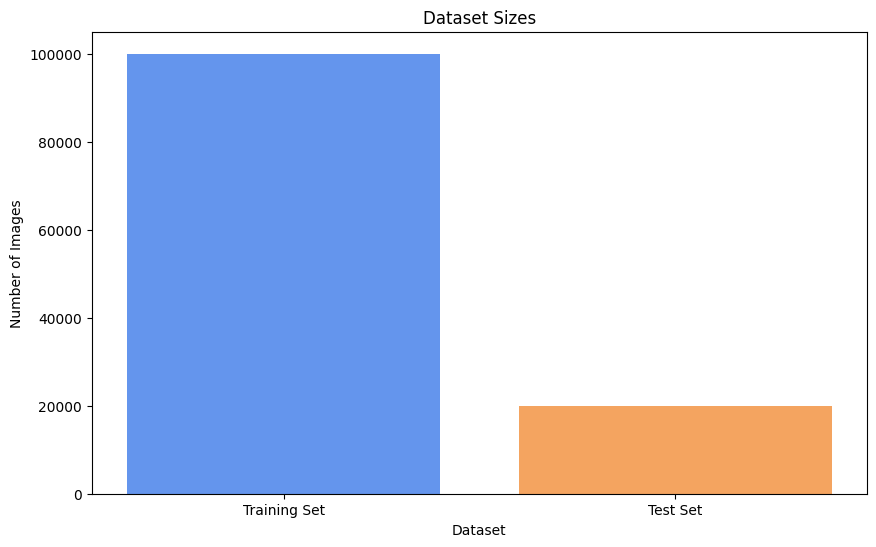

In [6]:
# Plot graphs showing the sizes of the training and test sets
dataset_sizes = [len(train_set), len(test_set)]
dataset_labels = ['Training Set', 'Test Set']

plt.figure(figsize=(10, 6))
plt.bar(dataset_labels, dataset_sizes, color=['cornflowerblue', 'sandybrown'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Dataset Sizes')
plt.show()

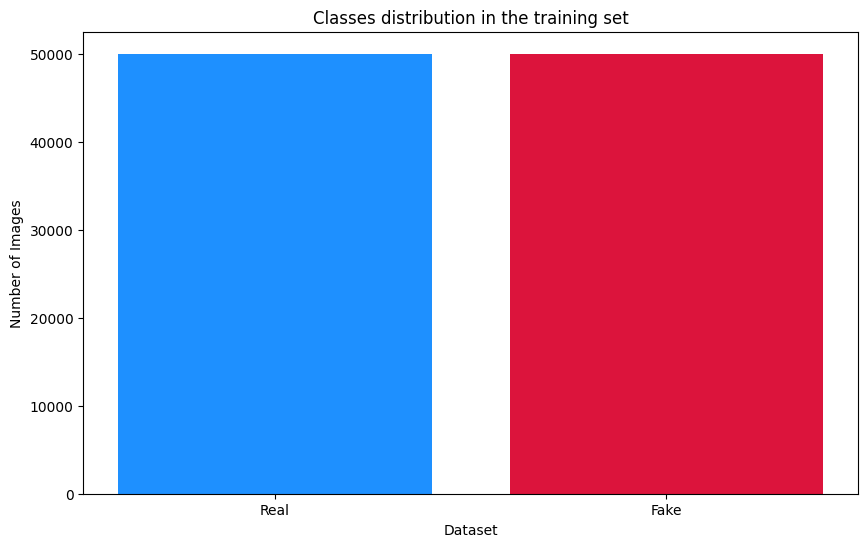

In [7]:
# Observe the number of images for each class in testset
real_count_train = sum(label == 0 for label in train_set.targets)
fake_count_train = sum(label == 1 for label in train_set.targets)

# Define labels and counts
train_set_labels = ['Real', 'Fake']
train_counts = [real_count_train, fake_count_train]

plt.figure(figsize=(10, 6))
plt.bar(train_set_labels, train_counts, color=['dodgerblue', 'crimson'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Classes distribution in the training set')
plt.show()

Applying transformations and visualizing them helps ensure that the data preprocessing and augmentation pipeline is correctly implemented before we start the training.
It also ensures that the transformations are enhancing the dataset in a way that will help the model generalize better to new / unseen data,
ultimately improving the model's performance and ensuring robustness.

We further split the training set into 80/20 training and validation sets.

### Data split

In [8]:
len_img=len(train_set)
len_train=int(0.8*len_img)
len_val=len_img-len_train

# Split Pytorch tensor
train_set,val_set=random_split(train_set,
                             [len_train,len_val]) # random split 80/20

print(f"Training set size: {len(train_set):,}")
print(f"Validation set size: {len(val_set):,}")
# TO-DO: Another graph now that we have a val set as well

Training set size: 80,000
Validation set size: 20,000


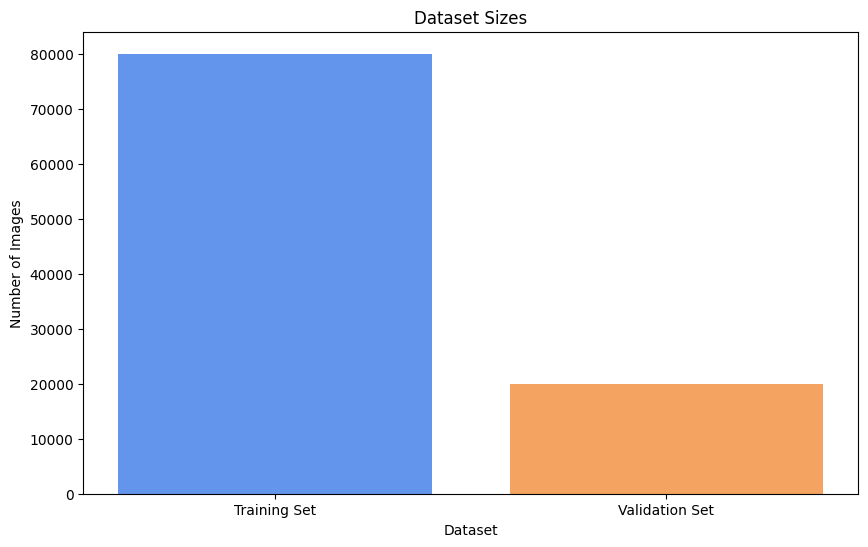

In [9]:
# Plot graphs showing the sizes of the training and test sets
dataset_sizes = [len(train_set), len(val_set)]
dataset_labels = ['Training Set', 'Validation Set']

plt.figure(figsize=(10, 6))
plt.bar(dataset_labels, dataset_sizes, color=['cornflowerblue', 'sandybrown'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Dataset Sizes')
plt.show()

### Preprocessing

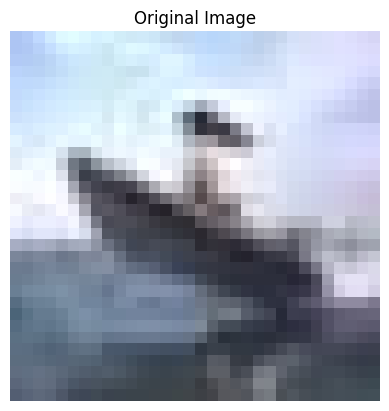

In [10]:
img, label = val_set[2] # TO-DO: Can we pick the image of a cat?

# Convert PIL Image to numpy array
img_np = np.array(img)

# Visualize the original image
plt.imshow(img_np)
plt.axis('off')
plt.title("Original Image")
plt.show()

In [11]:
# Transform the training and validation sets
train_set.dataset.transform = transform_set(set_type='training')
val_set.dataset.transform = transform_set(set_type='validation')

In [12]:
img, label = val_set[2]

val_transformed_img = transform_set(set_type='validation')

# # Convert PyTorch tensor to numpy array and rearrange dimensions
# val_transformed_img_np = np.transpose(val_transformed_img .numpy(),(1, 2, 0))

# # Convert PyTorch tensor to numpy array and rearrange dimensions
# img_np = np.transpose(img.numpy(), (1, 2, 0))

# # Visualize the transformed image
# plt.imshow(val_transformed_img_np)
# plt.axis('off')
# plt.title("Transformed Image")
# plt.show()


Augmentation techniques (e.g. random rotations, flips, color jittering) are typically applied only to the training set. The purpose of data augmentation is to artificially expand the training set and help the model generalize better by learning from varied examples. In other words, we don't want our model to fixate on irrelevant features like orientation, but capture the important ones instead. Augmentation should not be applied to the validation set because it should represent the true distribution of data the model will encounter in real-world scenarios.
:

*   Resize: all images have a uniform size, which is required for batch processing in neural networks     
*   Center crop: ensuring that the center of the image is retained. This is a common practice to standardize input sizes for models like those in the ResNet family.

Data augmentation
*   Random horizontal flip: Flips the image horizontally with a probability of 0.5. This helps the model become invariant to the horizontal orientation of objects, increasing its robustness.
*   Random rotation: Rotates the image by up to 30 degrees randomly. This adds variation to the dataset, helping the model learn to recognize objects from different angles.
*   Color jitter: Randomly changes the brightness and contrast of the image, simulating different lighting conditions. This makes the model more robust to changes in lighting in real-world scenarios.
*   Random channel permutation: Randomly permutes the RGB channels, which can help the model become invariant to color variations. This is especially useful if color is not a crucial feature for classification.
*   Normalization: For each channel using the specified mean and standard deviation.



In [13]:
img, label = train_set[1]

train_transformed_img = transform_set(set_type='training')

# # # Convert PyTorch tensor to numpy array and rearrange dimensions
# train_transformed_img_np = np.transpose(train_transformed_img.numpy(), (1, 2, 0))


# # # Convert to uint8 for OpenCV
# train_transformed_img_np_uint8 = (train_transformed_img_np * 255).astype(np.uint8)


# # Convert the transformed image to a tensor and add a batch dimension
# #Train_transformed_img = transforms.ToTensor()(Train_transformed_img)
# train_transformed_img = train_transformed_img.unsqueeze(0)

#-----------------------------------------------------------#

#Εδω κανουμε με resnet feature extraction , το κανω remark για να το δουμε στο Transfer learning!#

# # Load a pretrained ResNet model (Residual Network)
#  model = models.resnet50(pretrained=True)

# feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

# # # Ensure the model is in evaluation mode
# feature_extractor.eval()

# # # Extract features
# with torch.no_grad():features = feature_extractor(Train_transformed_img).squeeze()

# # # Convert features to a numpy array for further processing if needed
# features_np = features.numpy()

#------------------------------------------------------------#

# # Convert the transformed image to numpy array for SIFT
# train_transformed_img = train_transformed_img.squeeze().permute(1, 2, 0).numpy()
# train_transformed_img = np.clip((train_transformed_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])), 0, 1)
# train_transformed_img = (train_transformed_img * 255).astype(np.uint8)

# # ##Scale-Invariant Feature Transform (SIFT) algorithm to detect and visualize keypoints in a grayscale version of the image. --SIFT works on single-channel images, so the RGB image is converted to grayscale.
# gray = cv2.cvtColor(train_transformed_img_np_uint8, cv2.COLOR_RGB2GRAY)

# # Initialize SIFT detector
# sift = cv2.SIFT_create()

# # Detect keypoints
# key_points = sift.detect(gray, None)

# # Draw keypoints on the image
# img_with_kp = cv2.drawKeypoints(gray, key_points, None)

# # Create a figure
# fig = plt.figure(figsize=(12, 6))

# # Convert image from BGR to RGB for matplotlib
# img_rgb = cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB)

# fig.add_subplot(1, 3, 3)
# plt.imshow(img_rgb)
# plt.axis('off')
# plt.title("Transformed Image with SIFT Keypoints")
# plt.show()



In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Training

For the training we opted for 16 batches and shuffled the training and validation sets, without touching the test set.

In [15]:
# Batch size - change if we get an Out Of Memory error
batch_size = 64

# Training data loaders
train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, # Shuffle for every epoch
    num_workers=2, pin_memory=True # Changed num_workers to 2 from 4 after warning
)
# Validation data loaders
val_loader = DataLoader(
    val_set, batch_size=batch_size, shuffle=False, # No need to shuffle the validation set
    num_workers=2, pin_memory=True
)

# Test data loaders
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=False, # No need to shuffle the test set
    num_workers=2, pin_memory=True
)

### Neural network architecture

(add media)

We built our classifier with three convolutions layers (conv1, conv2, conv3) ending with 128 output channels, with ReLU activation functions, followed by max pooling layers (pool) and dropout. The fully connected layers (fc1, fc2, and fc3) process the output of the convolutional layers. We chose a kernel size of 3 and 1 padding.
We use Binary Cross Entropy loss which is appropriate for binary classification tasks like this one.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
def train_model(model, train_loader, val_loader, n_epochs=20, learning_rate=0.001):
    train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s = [], [], [], [], [], []

    since = time.time()

    # Create a temporary directory to save training checkpoints
    with tempfile.TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)

        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Check if GPU is available and move the model to GPU
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # Training loop
        for epoch in range(n_epochs):  # Loop over the dataset multiple times
            model.train()
            train_loss = 0.0
            train_acc = 0.0
            train_f1 = 0.0
            total_train_batches = len(train_loader)

            for train_images, train_labels in train_loader:
                # Move data to the GPU if available
                train_images, train_labels = train_images.to(device), train_labels.to(device)

                # Forward pass
                outputs = model(train_images)

                # Reshape labels to match the output shape
                train_labels = train_labels.view(-1, 1).float()

                # Compute loss
                loss = criterion(outputs, train_labels)

                # Backprop and update weights
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

                # Calculate accuracy and F1-score
                predictions = (outputs > 0.5).float()  # Apply threshold to convert probabilities to binary predictions
                train_acc += accuracy_score(train_labels.cpu().numpy(), predictions.cpu().numpy())
                train_f1 += f1_score(train_labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

            # Calculate average training loss, accuracy, and F1-score for the epoch
            avg_train_loss = train_loss / total_train_batches
            avg_train_acc = train_acc / total_train_batches
            avg_train_f1 = train_f1 / total_train_batches

            # Append average training metrics for this epoch
            train_losses.append(avg_train_loss)
            train_accuracies.append(avg_train_acc)
            train_f1s.append(avg_train_f1)

            # Validation step
            model.eval()
            val_loss = 0.0
            best_loss = 100
            val_acc = 0.0
            val_f1 = 0.0
            total_val_batches = len(val_loader)

            with torch.no_grad():
                for val_images, val_labels in val_loader:
                    # Move data to the GPU if available
                    val_images, val_labels = val_images.to(device), val_labels.to(device)

                    outputs = model(val_images)
                    val_labels = val_labels.view(-1, 1).float()
                    loss = criterion(outputs, val_labels)
                    val_loss += loss.item()

                    # Calculate accuracy and F1-score
                    predictions = (outputs > 0.5).float()  # Apply threshold to convert probabilities to binary predictions
                    val_acc += accuracy_score(val_labels.cpu().numpy(), predictions.cpu().numpy())
                    val_f1 += f1_score(val_labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

            # Calculate average validation loss, accuracy, and F1-score for the epoch
            avg_val_loss = val_loss / total_val_batches
            if avg_val_loss < best_loss:
              best_loss = avg_val_loss
            avg_val_acc = val_acc / total_val_batches
            avg_val_f1 = val_f1 / total_val_batches

            # Append average validation metrics for this epoch
            val_losses.append(avg_val_loss)
            val_accuracies.append(avg_val_acc)
            val_f1s.append(avg_val_f1)

            print(f'Epoch [{epoch+1}/{n_epochs}] - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}, Validation Accuracy: {avg_val_acc:.4f}, Training F1: {avg_train_f1:.4f}, Validation F1: {avg_val_f1:.4f}')

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best Validation loss: {best_loss:4f}')

        model.load_state_dict(torch.load(best_model_params_path))

    return model

In [17]:
train_model(model=ConvNet(), train_loader=train_loader, val_loader=val_loader)

Epoch [1/20] - Training Loss: 0.3363, Validation Loss: 0.2302, Training Accuracy: 0.8479, Validation Accuracy: 0.9078, Training F1: 0.8426, Validation F1: 0.9066
Epoch [2/20] - Training Loss: 0.1942, Validation Loss: 0.2147, Training Accuracy: 0.9236, Validation Accuracy: 0.9200, Training F1: 0.9223, Validation F1: 0.9189
Epoch [3/20] - Training Loss: 0.1343, Validation Loss: 0.1867, Training Accuracy: 0.9486, Validation Accuracy: 0.9300, Training F1: 0.9478, Validation F1: 0.9290
Epoch [4/20] - Training Loss: 0.0840, Validation Loss: 0.2117, Training Accuracy: 0.9687, Validation Accuracy: 0.9306, Training F1: 0.9681, Validation F1: 0.9297
Epoch [5/20] - Training Loss: 0.0569, Validation Loss: 0.2771, Training Accuracy: 0.9792, Validation Accuracy: 0.9261, Training F1: 0.9789, Validation F1: 0.9250
Epoch [6/20] - Training Loss: 0.0414, Validation Loss: 0.2321, Training Accuracy: 0.9847, Validation Accuracy: 0.9320, Training F1: 0.9844, Validation F1: 0.9310
Epoch [7/20] - Training Loss

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset

# Dummy model for testing
class DummyModel(nn.Module):
    def __init__(self):
        super(DummyModel, self).__init__()
        self.linear = nn.Linear(10, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Generate dummy data
x_train = torch.randn(100, 10)  # 100 samples, 10 features
y_train = torch.randint(0, 2, (100, 1)).float()  # Binary labels
x_val = torch.randn(20, 10)  # 20 samples, 10 features
y_val = torch.randint(0, 2, (20, 1)).float()  # Binary labels

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

# Function to train the model
def train_model(model, train_loader, val_loader, n_epochs=20, learning_rate=0.001):
    train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s = [], [], [], [], [], []

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Check if GPU is available and move the model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training loop
    for epoch in range(n_epochs):  # Loop over the dataset multiple times
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        train_f1 = 0.0
        total_train_batches = len(train_loader)

        for train_images, train_labels in train_loader:
            # Move data to the GPU if available
            train_images, train_labels = train_images.to(device), train_labels.to(device)

            # Forward pass
            outputs = model(train_images)

            # Reshape labels to match the output shape
            train_labels = train_labels.view(-1, 1).float()

            # Compute loss
            loss = criterion(outputs, train_labels)

            # Backprop and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy and F1-score
            predictions = (outputs > 0.5).float()  # Apply threshold to convert probabilities to binary predictions
            train_acc += accuracy_score(train_labels.cpu().numpy(), predictions.cpu().numpy())
            train_f1 += f1_score(train_labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

        # Calculate average training loss, accuracy, and F1-score for the epoch
        avg_train_loss = train_loss / total_train_batches
        avg_train_acc = train_acc / total_train_batches
        avg_train_f1 = train_f1 / total_train_batches

        # Append average training metrics for this epoch
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        train_f1s.append(avg_train_f1)

        # Validation step
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        val_f1 = 0.0
        total_val_batches = len(val_loader)

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                # Move data to the GPU if available
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                outputs = model(val_images)
                val_labels = val_labels.view(-1, 1).float()
                loss = criterion(outputs, val_labels)
                val_loss += loss.item()

                # Calculate accuracy and F1-score
                predictions = (outputs > 0.5).float()  # Apply threshold to convert probabilities to binary predictions
                val_acc += accuracy_score(val_labels.cpu().numpy(), predictions.cpu().numpy())
                val_f1 += f1_score(val_labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

        # Calculate average validation loss, accuracy, and F1-score for the epoch
        avg_val_loss = val_loss / total_val_batches
        avg_val_acc = val_acc / total_val_batches
        avg_val_f1 = val_f1 / total_val_batches

        # Append average validation metrics for this epoch
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)
        val_f1s.append(avg_val_f1)

        print(f'Epoch [{epoch+1}/{n_epochs}] - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}, Validation Accuracy: {avg_val_acc:.4f}, Training F1: {avg_train_f1:.4f}, Validation F1: {avg_val_f1:.4f}')

    print('Training complete')

# Instantiate and test the dummy model
dummy_model = DummyModel()
train_model(dummy_model, train_loader, val_loader, n_epochs=3)  # Testing with 3 epochs


Epoch [1/3] - Training Loss: 0.7355, Validation Loss: 0.6846, Training Accuracy: 0.5200, Validation Accuracy: 0.6000, Training F1: 0.5071, Validation F1: 0.5475
Epoch [2/3] - Training Loss: 0.7326, Validation Loss: 0.6851, Training Accuracy: 0.5100, Validation Accuracy: 0.6000, Training F1: 0.4626, Validation F1: 0.5475
Epoch [3/3] - Training Loss: 0.7300, Validation Loss: 0.6854, Training Accuracy: 0.5200, Validation Accuracy: 0.6000, Training F1: 0.5112, Validation F1: 0.5475
Training complete


In [24]:
# predictions = (outputs > 0.5).float()  # Thresholding at 0.5 for sigmoid output
# correct = torch.eq(predictions, labels).float().mean()
# accuracy = correct * 100  # Calculate percentage accuracy
# from sklearn.metrics import f1_score
# f1 = f1_score(labels.cpu().numpy(), predictions.cpu().numpy()) * 100
# print(f"Accuracy: {accuracy:.2f}%\nF1: {f1:.2f}%")

Total Iterations per Epoch:Given the training set size of 80,000 and a batch size of 64, the total number of iterations (mini-batches) per epoch is:

total_iterations = total_samples / batch_Size =
80000/64 = 1250
​

Printing Frequency:

You want to balance between too frequent and too infrequent logging. If you print too often, it might clutter the output and slightly slow down training due to I/O operations. If you print too infrequently, you might not get enough information to monitor training effectively.
A common approach is to print the running loss a few times per epoch.

For an 80,000-sample training set and a batch size of 64, a good approach could be to print the loss every 200 mini-batches. This way, you'll get around 6 updates per epoch (1250 iterations / 200 = 6.25), which provides a good balance between feedback frequency and performance overhead.

## Transfer learning